# Installation des bibliothèques

In [1]:
!rm -rf

In [2]:
%pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

# Importation des bibliothèques

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import shutil
from shutil import copyfile
import matplotlib.pyplot as plt
from PIL import Image
import random
import ultralytics
from ultralytics import YOLO
ultralytics.checks()

Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 42.2/112.6 GB disk)


# Télécharger le dataset PlantVillage

In [4]:
from google.colab import files
files.upload()  # Tu dois uploader le fichier kaggle.json ici

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nayaoussama","key":"fb187d9a33a1861e14be14c125763858"}'}

In [5]:
import os
import zipfile

# Crée le dossier .kaggle s'il n'existe pas
os.makedirs("/root/.kaggle", exist_ok=True)

# Déplace le fichier JSON vers ce dossier
!mv kaggle.json /root/.kaggle/

# Donne les permissions
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
# Télécharge le dataset (environ 800MB)
# !kaggle datasets download -d emmarex/plantdisease

!kaggle datasets download -d sebastianpalaciob/plantvillage-for-object-detection-yolo

Dataset URL: https://www.kaggle.com/datasets/sebastianpalaciob/plantvillage-for-object-detection-yolo
License(s): CC-BY-NC-SA-4.0
 92% 759M/829M [00:11<00:02, 35.8MB/s]
100% 829M/829M [00:11<00:00, 77.9MB/s]


In [9]:
# Crée un dossier pour le dataset
os.makedirs("plant_data", exist_ok=True)

# Dézippe dans le dossier
with zipfile.ZipFile("/content/plantvillage-for-object-detection-yolo.zip", 'r') as zip_ref:
    zip_ref.extractall("plant_data")

In [10]:
img_path='/content/plant_data/PlantVillage_for_object_detection/Dataset/images'
label_path='/content/plant_data/PlantVillage_for_object_detection/Dataset/labels'

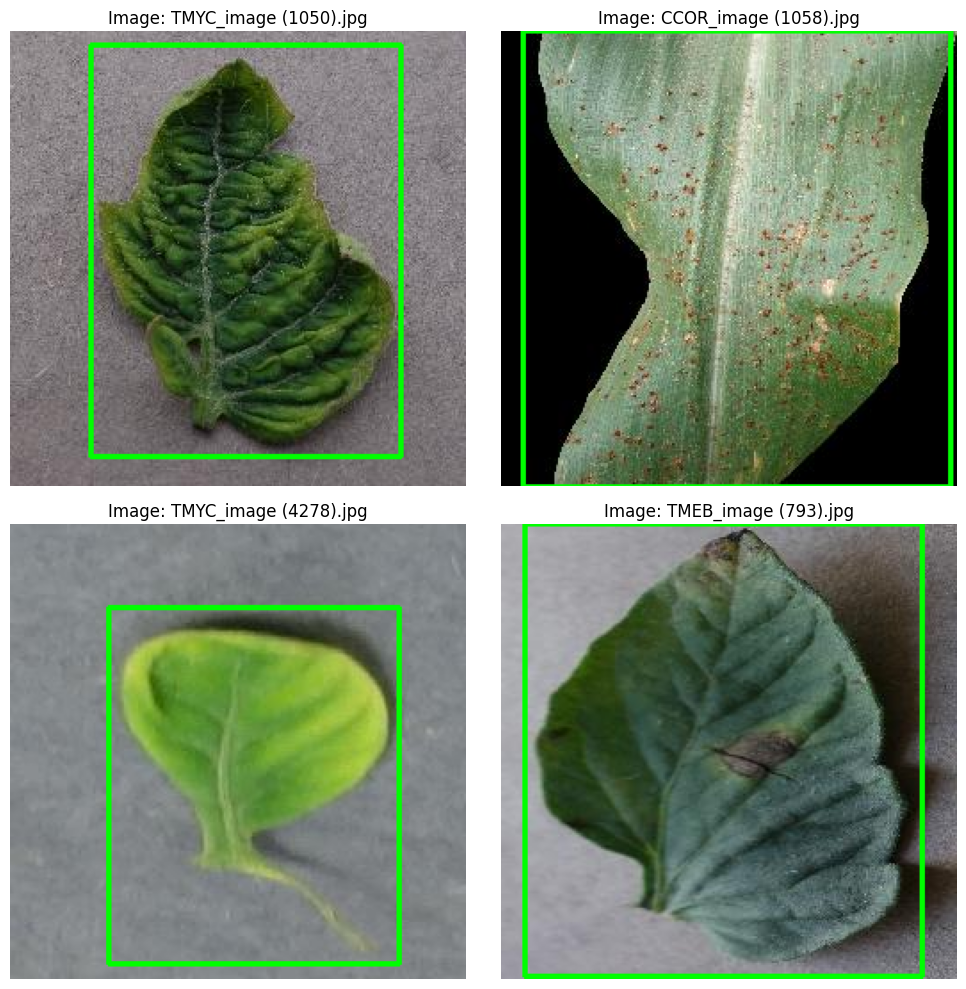

In [11]:
def draw_boxes_from_yolo(img, label_file):
    h, w, _ = img.shape

    with open(label_file, 'r') as f:
        lines = f.readlines()

        for line in lines:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center, y_center, width, height = map(float, parts[1:])

            x_center = int(x_center * w)
            y_center = int(y_center * h)
            width = int(width * w)
            height = int(height * h)

            x1 = int(x_center - width / 2)
            y1 = int(y_center - height / 2)
            x2 = int(x_center + width / 2)
            y2 = int(y_center + height / 2)

            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    return img

image_files = [f for f in os.listdir(img_path) if f.endswith('.jpg')][:4]

plt.figure(figsize=(10, 10))

for i, image_file in enumerate(image_files):
    img_file = os.path.join(img_path, image_file)
    label_file = os.path.join(label_path, image_file.replace('.jpg', '.txt'))

    img = cv2.imread(img_file)

    img_with_boxes = draw_boxes_from_yolo(img, label_file)

    img_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 2, i + 1)
    plt.imshow(img_rgb)
    plt.title(f"Image: {image_file}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Préparation du dataset (split train/val/test)

In [12]:
os.makedirs('datasets', exist_ok=True)
os.makedirs('datasets/train', exist_ok=True)
os.makedirs('datasets/valid', exist_ok=True)
os.makedirs('datasets/test', exist_ok=True)

In [13]:
image_files = [f for f in os.listdir(img_path) if f.endswith('.jpg')]

for i, image_file in enumerate(image_files):
    img_full_path = os.path.join(img_path, image_file)
    label_full_path = os.path.join(label_path, image_file.replace('.jpg', '.txt'))

    if os.path.exists(label_full_path):
        if i % 3 == 0:
            copyfile(img_full_path, f'datasets/train/{image_file}')
            copyfile(label_full_path, f'datasets/train/{image_file.replace(".jpg", ".txt")}')
        elif i % 3 == 1:
            copyfile(img_full_path, f'datasets/valid/{image_file}')
            copyfile(label_full_path, f'datasets/valid/{image_file.replace(".jpg", ".txt")}')
        else:
            copyfile(img_full_path, f'datasets/test/{image_file}')
            copyfile(label_full_path, f'datasets/test/{image_file.replace(".jpg", ".txt")}')

# Générer le fichier face.yaml

In [16]:
import yaml

face_yaml = dict(
    train ='/content/datasets/train',
    val ='/content/datasets/valid',
    test='/content/datasets/test',
    nc = 38,
    names = list(range(38))
)

with open('face.yaml', 'w') as outfile:
    yaml.dump(face_yaml, outfile, default_flow_style=True)

# Model YOLOv8 : l’entraînement

In [ ]:
#model = YOLO("yolov8n.pt")
#model = YOLO("yolov8m.pt")
#model = YOLO("yolov9c.pt")
#model = YOLO("yolov9t.pt")
#model = YOLO("yolov8s.pt")

#model.info()

#results = model.train(data="face.yaml", epochs=20, imgsz=640)

In [17]:
#!yolo task=detect mode=train model=yolov8m.pt data=face.yaml epochs=20 imgsz=640
!yolo train model=yolov8s.pt data=face.yaml epochs=20 imgsz=640

Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=face.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=Fal

In [ ]:
#metrics = results.metrics
#results.show()

In [ ]:
#metrics

In [ ]:
#model.export(format='onnx')

# Test


image 1/1 /content/datasets/test/APAS_image (1).jpg: 640x640 1 0, 16.4ms
Speed: 5.0ms preprocess, 16.4ms inference, 159.2ms postprocess per image at shape (1, 3, 640, 640)


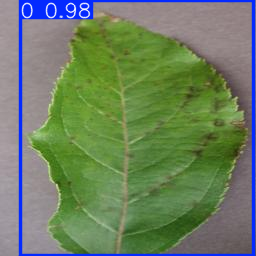

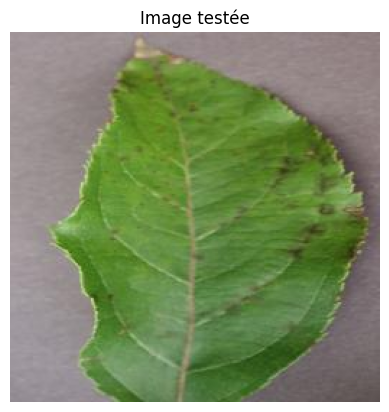

In [19]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Charger le modèle entraîné
model = YOLO('/content/runs/detect/train2/weights/best.pt')  # Le chemin peut changer selon le nom du dossier

# Image à tester (change ce chemin selon ton image)
image_path = '/content/datasets/test/APAS_image (1).jpg'
labell_path = '/content/datasets/test/APAS_image (1).txt'

# Faire une prédiction
results = model(image_path)

# Afficher l’image avec les détections
results[0].show()

# Ou en matplotlib si tu veux personnaliser
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.title("Image testée")
plt.show()

In [21]:
# Liste des noms (indexés de 0 à 37)
disease_names = [
    "Apple___Apple_scab",
    "Apple___Black_rot",
    "Apple___Cedar_apple_rust",
    "Apple___healthy",
    "Blueberry___healthy",
    "Cherry___Powdery_mildew",
    "Cherry___healthy",
    "Corn___Cercospora_leaf_spot Gray_leaf_spot",
    "Corn___Common_rust",
    "Corn___Northern_Leaf_Blight",
    "Corn___healthy",
    "Grape___Black_rot",
    "Grape___Esca_(Black_Measles)",
    "Grape___Leaf_blight_(Isariopsis_Leaf_Spot)",
    "Grape___healthy",
    "Orange___Haunglongbing_(Citrus_greening)",
    "Peach___Bacterial_spot",
    "Peach___healthy",
    "Pepper,_bell___Bacterial_spot",
    "Pepper,_bell___healthy",
    "Potato___Early_blight",
    "Potato___Late_blight",
    "Potato___healthy",
    "Raspberry___healthy",
    "Soybean___healthy",
    "Squash___Powdery_mildew",
    "Strawberry___Leaf_scorch",
    "Strawberry___healthy",
    "Tomato___Bacterial_spot",
    "Tomato___Early_blight",
    "Tomato___Late_blight",
    "Tomato___Leaf_Mold",
    "Tomato___Septoria_leaf_spot",
    "Tomato___Spider_mites Two-spotted_spider_mite",
    "Tomato___Target_Spot",
    "Tomato___Tomato_Yellow_Leaf_Curl_Virus",
    "Tomato___Tomato_mosaic_virus",
    "Tomato___healthy"
]

# Affichage personnalisé avec noms
for box in results[0].boxes:
    cls_id = int(box.cls[0].item())
    conf = box.conf[0].item()
    print(f"🟢 Maladie détectée : {disease_names[cls_id]} ({cls_id}) avec {conf*100:.2f}% de confiance")

🟢 Maladie détectée : Apple___Apple_scab (0) avec 97.77% de confiance
